In [1]:
%matplotlib inline


Language Translation with Transformer
=====================================

This tutorial shows, how to train a translation model from scratch using
Transformer. We will be using Multi30k dataset to train a German to English translation model.



## Data Processing




In [1]:
import math
import torchtext
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from torch import Tensor
from torch.optim.lr_scheduler import StepLR,LambdaLR
from torch.utils.data import DataLoader
import time
from utils import *
from my_transformer import *
import matplotlib.pyplot as plt
import numpy as np
import csv

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)

In [2]:
pth_base = "./.data/multi30k/task1/raw/"
train_pths = ('train.de', 'train.en')
val_pths = ('val.de', 'val.en')
test_pths = ('test_2016_flickr.de', 'test_2016_flickr.en')

train_filepaths = [(pth_base + pth) for pth in train_pths]
val_filepaths = [(pth_base + pth) for pth in val_pths]
test_filepaths = [(pth_base + pth) for pth in test_pths]

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

de_vocab = build_vocab(train_filepaths[0], de_tokenizer, min_freq=3)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer, min_freq=3)
    
def data_process(filepaths):
    raw_de_iter = iter(open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(open(filepaths[1], encoding="utf8"))
    data = []
    for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
        de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de.lower().rstrip("\n"))], dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en.lower().rstrip("\n"))], dtype=torch.long)
        data.append((de_tensor_, en_tensor_))

    return data

train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)
print("train size:", len(train_data))
print("val size:", len(val_data))
print("test size:", len(test_data))
print("de vocab size:", len(de_vocab))
print("en vocab size:", len(en_vocab))

cpu
train size: 29000
val size: 1014
test size: 1000
de vocab size: 5374
en vocab size: 4555


In [5]:
SRC_VOCAB_SIZE = len(de_vocab)
TGT_VOCAB_SIZE = len(en_vocab)
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3 # no help, 3 is better
NUM_DECODER_LAYERS = 3 # no help, 3 is better
EMB_SIZE = 256
FFN_HID_DIM = 512
NHEAD = 8 # no help, hard converge
DROPOUT = 0.1
NUM_EPOCHS = 50
LEARNING_RATE = 0.0001

LR_STEP = 30
warmup_steps = 4000
model_name = "./models/transformer-5-22-2"

param_list = [model_name,BATCH_SIZE,NUM_ENCODER_LAYERS,NUM_DECODER_LAYERS,EMB_SIZE,FFN_HID_DIM,NHEAD,DROPOUT,NUM_EPOCHS,LEARNING_RATE]
with open("./parameters/params_history.csv","a+") as f:
#     f.write("model_name,BATCH_SIZE,NUM_ENCODER_LAYERS,NUM_DECODER_LAYERS,EMB_SIZE,FFN_HID_DIM,NHEAD,DROPOUT,NUM_EPOCHS,LEARNING_RATE\n")
    csv_writer = csv.writer(f)
    csv_writer.writerow(param_list)

DataLoader
----------

The last torch specific feature we’ll use is the DataLoader, which is
easy to use since it takes the data as its first argument. Specifically,
as the docs say: DataLoader combines a dataset and a sampler, and
provides an iterable over the given dataset. The DataLoader supports
both map-style and iterable-style datasets with single- or multi-process
loading, customizing loading order and optional automatic batching
(collation) and memory pinning.

Please pay attention to collate_fn (optional) that merges a list of
samples to form a mini-batch of Tensor(s). Used when using batched
loading from a map-style dataset.




In [4]:
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=gen_collate_fn(PAD_IDX,BOS_IDX,EOS_IDX))
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=gen_collate_fn(PAD_IDX,BOS_IDX,EOS_IDX))
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=gen_collate_fn(PAD_IDX,BOS_IDX,EOS_IDX))

NameError: name 'BATCH_SIZE' is not defined

Transformer!
------------

Transformer is a Seq2Seq model introduced in `“Attention is all you
need” <https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>`__
paper for solving machine translation task. Transformer model consists
of an encoder and decoder block each containing fixed number of layers.

Encoder processes the input sequence by propogating it, through a series
of Multi-head Attention and Feed forward network layers. The output from
the Encoder referred to as ``memory``, is fed to the decoder along with
target tensors. Encoder and decoder are trained in an end-to-end fashion
using teacher forcing technique.




Text tokens are represented by using token embeddings. Positional
encoding is added to the token embedding to introduce a notion of word
order.




We create a ``subsequent word`` mask to stop a target word from
attending to its subsequent words. We also create masks, for masking
source and target padding tokens




Define model parameters and instantiate model 




In [7]:
# DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, 
                                 EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM, DROPOUT)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

lrate = lambda step_num: EMB_SIZE**-0.5 * np.minimum(step_num**-0.5,step_num*warmup_steps**-1.5)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)

scheduler = StepLR(optimizer, step_size=LR_STEP, gamma=0.1)

In [8]:
# tspan = np.linspace(1,20000)
# plt.plot(tspan, lrate(tspan))
# plt.xlabel("steps"),plt.ylabel("learning rate")
# plt.show()

In [9]:
print(f'The model has {count_parameters(transformer):,} trainable parameters')

The model has 7,667,147 trainable parameters


## Train Model and Save Checkpoints




In [10]:
def train_epoch(model, train_iter, optimizer):
    global steps
    model.train()
    losses = 0
    for idx, (src, tgt) in enumerate(train_iter):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, PAD_IDX, device)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optimizer.step()
        
        steps += 1
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lrate(steps)
            
        losses += loss.item()
    return losses / len(train_iter)

def evaluate(model, val_iter):
    model.eval()
    losses = 0
    for idx, (src, tgt) in (enumerate(valid_iter)):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, PAD_IDX, device)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
    return losses / len(val_iter)

In [11]:
train_loss_curve = []
val_loss_curve = []
min_val_loss = 999
steps = 1

In [12]:
for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    train_loss = train_epoch(transformer, train_iter, optimizer)
    end_time = time.time()
    val_loss = evaluate(transformer, valid_iter)
#     scheduler.step()
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        transformer.eval()
        torch.save(transformer, model_name+"-best.pth.tar")
        
    if epoch % 30 == 0:
        transformer.eval()
        torch.save(transformer, model_name+"-ckpt-"+str(epoch)+".pth.tar")
        
    train_loss_curve.append(train_loss)
    val_loss_curve.append(val_loss)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 5.497, Val loss: 4.246, Epoch time = 32.498s
Epoch: 2, Train loss: 4.006, Val loss: 3.551, Epoch time = 32.219s
Epoch: 3, Train loss: 3.521, Val loss: 3.170, Epoch time = 32.383s
Epoch: 4, Train loss: 3.197, Val loss: 2.876, Epoch time = 32.443s
Epoch: 5, Train loss: 2.942, Val loss: 2.662, Epoch time = 32.283s
Epoch: 6, Train loss: 2.738, Val loss: 2.493, Epoch time = 32.581s
Epoch: 7, Train loss: 2.569, Val loss: 2.359, Epoch time = 32.416s
Epoch: 8, Train loss: 2.424, Val loss: 2.244, Epoch time = 32.503s
Epoch: 9, Train loss: 2.300, Val loss: 2.153, Epoch time = 32.533s
Epoch: 10, Train loss: 2.188, Val loss: 2.070, Epoch time = 32.553s
Epoch: 11, Train loss: 2.091, Val loss: 1.997, Epoch time = 32.408s
Epoch: 12, Train loss: 2.002, Val loss: 1.941, Epoch time = 32.529s
Epoch: 13, Train loss: 1.921, Val loss: 1.883, Epoch time = 32.463s
Epoch: 14, Train loss: 1.849, Val loss: 1.842, Epoch time = 32.465s
Epoch: 15, Train loss: 1.782, Val loss: 1.792, Epoch time

In [13]:
print("min val loss:",min_val_loss)

min val loss: 1.5471777766942978


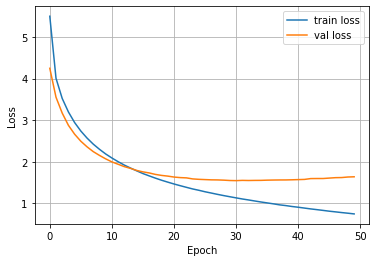

In [14]:
plt.plot(train_loss_curve)
plt.plot(val_loss_curve)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(("train loss","val loss"))
plt.savefig("./images/" + model_name.split(sep="/")[-1] + ".png")
plt.show()

In [15]:
translate(transformer, "eine gruppe von menschen steht vor einem iglu .", de_vocab, en_vocab, de_tokenizer, BOS_IDX, EOS_IDX, device)

' a group of people standing in front of a <unk> <unk> . '

## Save Transformer

In [16]:
transformer.eval()
torch.save(transformer, model_name + ".pth.tar")

In [17]:
'''make predictions'''
predictions = []
'''load reference'''
with open(test_filepaths[0], 'r', encoding='utf8') as f:
    test_data_ = f.readlines()
    
for data in test_data_:
    temp_trans = translate(transformer, data.lower(), de_vocab, en_vocab, de_tokenizer, BOS_IDX, EOS_IDX, device)
    predictions.append(temp_trans[1:-3]+" . \n")

'''update predictions.txt'''
with open("predictions.txt",'w+') as f:
    f.writelines(predictions)

In [23]:
# for i,pre in enumerate(predictions):
#     predictions[i] = pre.replace("<unk>"," ")
# '''update predictions.txt'''
# with open("predictions.txt",'w+') as f:
#     f.writelines(predictions)

In [24]:
! perl ./multi-bleu.perl -lc reference.txt < predictions.txt

with open(model_name + ".txt",'w+') as f:    
    f.writelines(predictions)

BLEU = 37.37, 69.5/45.0/30.1/20.7 (BP=1.000, ratio=1.002, hyp_len=13084, ref_len=13058)


In [35]:
from torchtext.data.metrics import bleu_score
references_corpus  = []
candidate_corpus = []
'''update reference.txt'''
'''update reference.txt'''
with open(test_filepaths[1], 'r', encoding='utf8') as f:
    reference = f.readlines()

for i in range(len(reference)):
    reference[i] = " ".join(en_tokenizer(reference[i])).lower()

for pred,ref in zip(predictions, reference):
    temp = pred.rstrip(" \n").split(" ")
    candidate_corpus.append(temp)
    temp = ref.rstrip(" \n").split(" ")
    references_corpus.append([temp])
bleu_torchtext = bleu_score(candidate_corpus, references_corpus)
print(f'BLEU score = {bleu_torchtext*100:.2f}')

BLEU score = 37.20
